# Banking Fraud with various Predictions

## Setup

Import AWS specific modules and specify S3 data location

In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install --upgrade seaborn
# !{sys.executable} -m pip install --upgrade imbalanced-learn
import boto3
import os
from random import seed, sample
import sagemaker
import sagemaker.amazon.amazon_estimator
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer

Import python ML modules

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_context("paper")

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
# from xgboost.sklearn import XGBClassifier

In [3]:
bucket = 'sagemaker-pmelvin'
prefix = 'compile_xgb_v3'
hp_prefix = 'hp_tuning_v3'

csv_data = 'input-data/bb_banking_fraud.csv'
csv_removed_types = 'input-data/removed-specific-types/01a89090-e9b6-4b07-8a49-b0244d6dc035.csv'
full_data_location = 's3://{}/{}'.format(bucket, csv_data)
clean_data_location = 's3://{}/{}'.format(bucket, csv_data)

#local_file = 'bb_banking_fraud.csv'

role = get_execution_role()
sess = sagemaker.Session()
smclient = boto3.Session().client('sagemaker')

## Data

In [4]:
%%time
df_full = pd.read_csv(full_data_location)

CPU times: user 9.86 s, sys: 2.23 s, total: 12.1 s
Wall time: 24.9 s


In [5]:
# %%time
# df_clean = pd.read_csv(clean_data_location)

In [6]:
# df.head(n=5)

In [7]:
df_u = df_full.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest', 'isfraud':'isFraud'})

In [8]:
# df_u.head(n=5)

In [9]:
# df.shape

In [10]:
df_u_copy = df_u.copy()

df_u['hourOfDay'] = np.nan
df_u.hourOfDay = df_u_copy.step % 24

In [11]:
first_col = df_u.pop('isFraud')

In [12]:
df_u.insert(0, 'isFraud', first_col)

In [13]:
df_u.head(n=5)

,isFraud,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,hourOfDay
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,1
1,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,1
2,1,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,1
3,1,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,1
4,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,1


In [14]:
counts = df_u['isFraud'].value_counts()
counts

0    6354407
1       8213
Name: isFraud, dtype: int64

In [15]:
counts / df_u.shape[0]

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [16]:
sample = df_u.sample(n=10000, random_state=42)

In [17]:
sample.head(n=5)

,isFraud,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,hourOfDay
3737323,0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,14
264914,0,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,15
85647,0,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,10
5899326,0,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,19
2544263,0,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,14


In [18]:
sample.isFraud.value_counts()

0    9981
1      19
Name: isFraud, dtype: int64

In [19]:
def get_features(df):
    
    selected_cols = [
        'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
        'oldBalanceDest', 'newBalanceDest', 'isFraud', 'hourOfDay'
    ]
    
    df = df[selected_cols].copy()
    dummies = pd.get_dummies(df.type)
    df = pd.concat([df, dummies], axis=1).drop("type", axis=1)
    
    return df

In [20]:
def reduce_data(pca_df):
    pca_df = pca_df.copy()
    target = pca_df.pop("isFraud")
    scaler = StandardScaler()
    pca_df = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    components = pca.fit_transform(pca_df)

    comp_df = pd.DataFrame(components, columns=["X", "y"])
    target = target.reset_index(drop=True)
    plot_df = pd.concat([comp_df, target], axis=1)
    
    return plot_df

In [21]:
def fraud_plot(plot_df, maj_alpha=0.5, min_alpha=1, save=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.scatterplot(x="X", y="y", alpha=maj_alpha, data=plot_df[plot_df.isFraud == 0], label="Legitimate")
    sns.scatterplot(x="X", y="y", alpha=min_alpha, data=plot_df[plot_df.isFraud == 1], ax=ax, label="Fraud")
    plt.title("Legitimate vs Fraudulent Purchases")
    plt.tight_layout()
    if save != None:
        plt.savefig(save)
    plt.show()
    
    pass

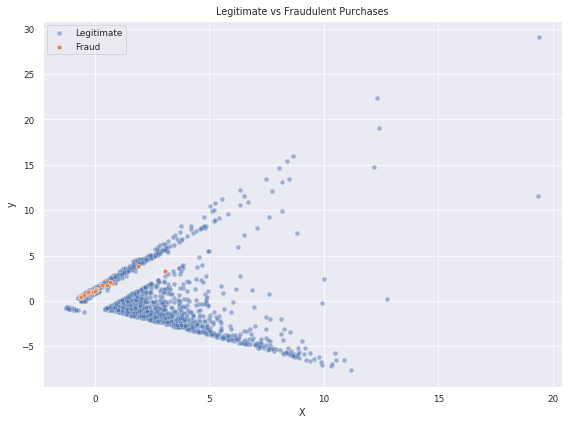

In [22]:
processed_data = get_features(sample)
plot_df = reduce_data(processed_data)
fraud_plot(plot_df)

In [23]:
# processed_data.shape

In [24]:
# processed_data.head(n=5)

In [25]:
from imblearn.under_sampling import RandomUnderSampler

In [26]:
RUS = RandomUnderSampler(sampling_strategy={0: 9589}, random_state=42)

In [27]:
def resample(df, method):
    processed_df = get_features(df)
    target = processed_df.pop('isFraud')

    processed_x, processed_y = method.fit_resample(processed_df, target)

    cols = list(processed_df.columns) + ["isFraud"]

    pdf_x = pd.DataFrame(processed_x, columns=processed_df.columns)
    pdf_y = pd.DataFrame(processed_y, columns=['isFraud'])
    resampled_df = pd.concat([pdf_x, pdf_y], axis=1)
    
    return resampled_df

In [28]:
%%time
rus_resampled = resample(df_u, RUS)
print(rus_resampled.shape)
print(rus_resampled.isFraud.value_counts())

(17802, 12)
0    9589
1    8213
Name: isFraud, dtype: int64
CPU times: user 2.51 s, sys: 916 ms, total: 3.42 s
Wall time: 3.42 s


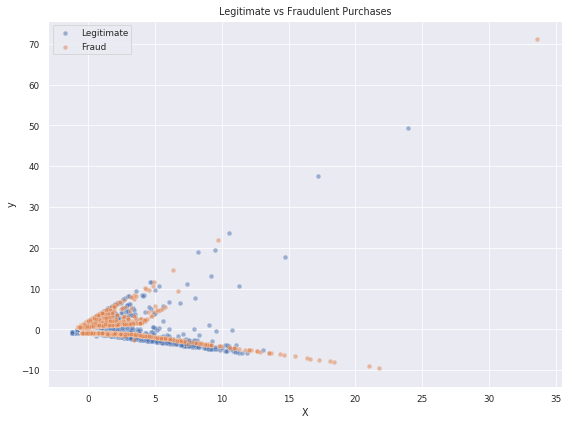

In [29]:
fraud_plot(reduce_data(rus_resampled), min_alpha=0.5)

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
SM = SMOTE(random_state=42)

In [32]:
%%time
sm_resampled = resample(df_u, SM)
print(sm_resampled.shape)
print(sm_resampled.isFraud.value_counts())

(12708814, 12)
1    6354407
0    6354407
Name: isFraud, dtype: int64
CPU times: user 4.2 s, sys: 2.05 s, total: 6.25 s
Wall time: 6.25 s


In [33]:
sm_sample = sm_resampled.sample(n=10000, random_state=42)

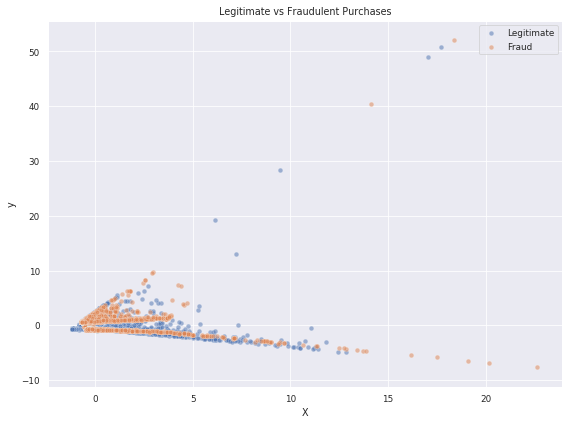

In [34]:
fraud_plot(reduce_data(sm_sample), min_alpha=0.5)


## Splitting and standardising

In [35]:
# to allow reproducible splitting we define a RandomState and seed
# randomstate = 25
# seed(10)

In [36]:
first_col = rus_resampled.pop('isFraud')
rus_resampled.insert(0, 'isFraud', first_col)

In [37]:
rus_resampled.head()

,isFraud,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,hourOfDay,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,183806.32,19391.00,0.00,382572.19,566378.51,18,0,1,0,0,0
1,0,521.37,0.00,0.00,0.00,0.00,17,0,0,0,1,0
2,0,3478.18,19853.00,16374.82,0.00,0.00,11,0,0,0,1,0
3,0,1716.05,5769.17,4053.13,0.00,0.00,19,0,0,0,1,0
4,0,253129.93,1328499.49,1581629.42,2713220.48,2460090.55,18,1,0,0,0,0


In [38]:
##

# columns = list(rus_resampled)



In [39]:
##

# train_df, val_df = train_test_split(rus_resampled, test_size=0.20, random_state=42)
# val_df, test_df = train_test_split(val_df, test_size=0.05, random_state=42)

# # Set the index for our test dataframe
# test_df.reset_index(inplace=True, drop=True)

# print('split train: {}, val: {}, test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))



In [40]:
X = rus_resampled.drop('isFraud', 1)
y = rus_resampled.isFraud

In [41]:
# X.head(n=5)
# X.shape

In [42]:
# y.head(n=5)
# y.shape

We will split the dataset with a 80% for training, 15% for validation and 5% for testing data

In [43]:
train_ratio = 0.80
validation_ratio = 0.15
test_ratio = 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42, shuffle=True, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42, shuffle=True, stratify=y) 

print('split train: {}, val: {}, test: {} '.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

split train: 14241, val: 2670, test: 891 


In [44]:
# X_train, X_val, X_test = np.split(rus_resampled.sample(frac=1), [int(0.7 * len(rus_resampled)), int(0.9 * len(rus_resampled))])

In [45]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

scaler.fit(X_train)

MinMaxScaler()

In [46]:
# old way

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# X_val = scaler.transform(X_val)

In [47]:
#
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test  = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)
X_val   = pd.DataFrame(scaler.fit_transform(X_val),columns = X_val.columns)

In [48]:
#
X_train_ins = X_train.copy()
X_test_ins  = X_test.copy()
X_val_ins   = X_val.copy()

X_train_ins.insert(0, 'isFraud', y_train.values)
X_test_ins.insert(0, 'isFraud', y_test.values)
X_val_ins.insert(0, 'isFraud', y_val.values)

In [49]:
#
X_train.to_csv('train.csv', index=False, header=False)
X_val.to_csv('validation.csv', index=False, header=False)

# Save test and baseline with headers
X_test.to_csv('test.csv', index=False, header=True)
X_train.to_csv('baseline.csv', index=False, header=True)

In [50]:
#
# convert to numpy arrays for later use
X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()
X_val   = X_val.to_numpy()

In [51]:
# # Save train and validation
# X_train_ins.to_csv('train.csv', index=False, header=False)
# X_val_ins.to_csv('validation.csv', index=False, header=False)

# # Save test and baseline with headers
# X_test_ins.to_csv('test.csv', index=False, header=True)
# X_train_ins.to_csv('baseline.csv', index=False, header=True)

In [52]:
#
# X_train_ins = X_train_ins.to_numpy()
# X_test_ins  = X_test_ins.to_numpy()
# X_val_ins   = X_val_ins.to_numpy()

In [53]:
# old way

# np.savetxt('train.csv', X_train, delimiter=',')
# np.savetxt('test.csv', X_test, delimiter=',')
# np.savetxt('validation.csv', X_val, delimiter=',')

In [54]:
# old way

# boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
# s3_train_location = 's3://{}/{}/train'.format(bucket, prefix)
# print('Uploaded training data location: {}'.format(s3_train_location))

# boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
# s3_test_location = 's3://{}/{}/test'.format(bucket, prefix)
# print('Uploaded test data location: {}'.format(s3_test_location))

# boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
# s3_validation_location = 's3://{}/{}/validation'.format(bucket, prefix)
# print('Uploaded validation data location: {}'.format(s3_validation_location))

# s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
# print('Training artifacts will be uploaded to: {}'.format(s3_output_location))

In [55]:
# old way
# s3_input_train = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'train'), content_type='text/csv')
# s3_input_validation = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'validation'), content_type='text/csv')

In [56]:
pl_prefix = 'pipeline'

s3_train_uri = sess.upload_data('train.csv', bucket, pl_prefix + '/data/training')
print('Uploaded training data location: {}'.format(s3_train_uri))

s3_val_uri = sess.upload_data('validation.csv', bucket, pl_prefix + '/data/validation')
print('Uploaded validation data location: {}'.format(s3_val_uri))

s3_baseline_uri = sess.upload_data('baseline.csv', bucket, pl_prefix + '/data/baseline')
print('Uploaded validation data location: {}'.format(s3_baseline_uri))

s3_output_location = 's3://{}/{}/output'.format(bucket, pl_prefix)
print('Training artifacts will be uploaded to: {}'.format(s3_output_location))

Uploaded training data location: s3://sagemaker-pmelvin/pipeline/data/training/train.csv
Uploaded validation data location: s3://sagemaker-pmelvin/pipeline/data/validation/validation.csv
Uploaded validation data location: s3://sagemaker-pmelvin/pipeline/data/baseline/baseline.csv
Training artifacts will be uploaded to: s3://sagemaker-pmelvin/pipeline/output


In [57]:
s3_input_train = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, pl_prefix, 'data/training'), content_type='text/csv')
s3_input_validation = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, pl_prefix, 'data/validation'), content_type='text/csv')

In [58]:
xgboost_container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1.0-1')

In [59]:
instance_type='ml.m5.xlarge'

hyperparameters = {
        "alpha":"0.2",
        "max_depth":"10",
        "eta":"0.12",
        "gamma":"2.0",
        "min_child_weight":"8.5",
        "subsample":"0.6",
        "objective":"binary:logistic",
        "num_round":"20",
        "eval_metric":"auc"
        }

In [60]:
smote_xgb = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(), 
                                          instance_count=1, 
                                          instance_type=instance_type,
                                          output_path=s3_output_location,
                                          sagemaker_session=sess)

In [61]:
%%time
smote_xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

# use if you only want to train and not validate
# smote_xgb.fit({'train': s3_input_train})

2021-01-07 15:51:33 Starting - Starting the training job...ProfilerReport-1610034693: InProgress
............
2021-01-07 15:53:58 Starting - Launching requested ML instances.........
2021-01-07 15:55:19 Starting - Preparing the instances for training......
2021-01-07 15:56:26 Downloading - Downloading input data
2021-01-07 15:56:26 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV in

In [62]:
%%time
deploy_instance_type='ml.m5.large'
smote_predictor = smote_xgb.deploy(initial_instance_count=1,
                                   model_name="xgb-smote-model-02",
                                   endpoint_name="xgb-smote-endpoint-02",
                                   instance_type=deploy_instance_type,
                                   serializer=CSVSerializer(),
                                   deserializer=None)

---------------!CPU times: user 214 ms, sys: 9.93 ms, total: 223 ms
Wall time: 7min 32s


In [63]:
# use if already deployed

# endpoint_name = "xgb-smote-endpoint-02"
# smote_predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

Once we have trained the model we can use it to make predictions for the test dataset

In [64]:
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [65]:
%%time
smote_raw_predictions = predict(smote_predictor, X_test[:, 1:])

CPU times: user 24.2 ms, sys: 2.73 ms, total: 27 ms
Wall time: 210 ms


In [66]:
smote_binary_predictions = np.where(smote_raw_predictions > 0.5, 1, 0)

In [67]:
%%time
y_train_preds = predict(smote_predictor, X_train[:, 1:])

CPU times: user 219 ms, sys: 4.16 ms, total: 223 ms
Wall time: 942 ms


In [68]:
%%time
y_valid_preds = predict(smote_predictor, X_val[:, 1:])

CPU times: user 45.5 ms, sys: 4.36 ms, total: 49.9 ms
Wall time: 171 ms


Now we have all of the various pieces we need to visualise these numbers, we will be using:

- auc
- accuracy
- recall
- precision
- specificity

and then a confusion matrix and a ROC curve!

**auc**

AUC means area under the curve so to speak about ROC AUC score we need to define ROC curve first. 

It is a chart that visualizes the tradeoff between true positive rate (TPR) and false positive rate (FPR). Basically, for every threshold, we calculate TPR and FPR and plot it on one chart.

**accuracy**

It measures how many observations, both positive and negative, were correctly classified.

**recall**

Recall is the ratio of the correctly +ve labeled, i.e. which transactions are actually fraudulent

**precision**

Precision is the ratio of the correctly +ve labeled by our program to all +ve labeled.

**specificity**

Specificity is the *correctly* -ve labeled by the program

First, we have define some functions to output all the above

In [69]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)

    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity

Now, let's have a look at our results

In [70]:
thresh = 0.1

print('XGBoost Classifier')
print('Training:')
xgb_train_auc, xgb_train_accuracy, xgb_train_recall, xgb_train_precision, xgb_train_specificity = print_report(y_train, y_train_preds, thresh)

print('Validation:')
xgb_valid_auc, xgb_valid_accuracy, xgb_valid_recall, xgb_valid_precision, xgb_valid_specificity = print_report(y_val, y_valid_preds, thresh)

XGBoost Classifier
Training:
AUC:0.767
accuracy:0.683
recall:0.332
precision:0.939
specificity:0.982
 
Validation:
AUC:0.752
accuracy:0.688
recall:0.388
precision:0.884
specificity:0.955
 


Now let's have a look at the confusion matrix

In [71]:
def plot_confusion_matrix(y_test, y_pred):

    cm  = confusion_matrix(y_test, y_pred)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    plt.show()

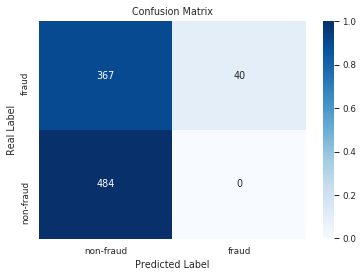

In [72]:
# plot_confusion_matrix(y_test, smote_binary_predictions)
plot_confusion_matrix(y_test, smote_binary_predictions)

and now let's have a look at a ROC curve

AUC is 0.7674


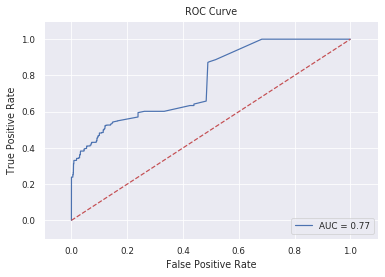

In [73]:
from sklearn import metrics

auc = round(roc_auc_score(y_train, y_train_preds), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_train, y_train_preds)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


TODO

The question is how to improve on the above as although it is ok it is far from from perfect

What we need to do is change the hyperparamters but there are a lot of hyperparamters and an almost infinite numbe of possibilities

We need some sort of automation, is there anything?

**Hyperperamater Tuning** to the rescue!

from the offical documentation

*Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.*

We have to define some more information for the tuner, which most importantly includes the hyperparameter ranges to test between

In [74]:
from time import gmtime, strftime

tuning_job_name = 'xgboost-tuning-job-' + strftime("%d-%H-%M-%S", gmtime())
s3_tuning_output = 's3://{}/{}/{}'.format(bucket, hp_prefix, tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "8",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "0.8",
          "MinValue": "0.1",
          "Name": "eta"
        },
        {
          "MaxValue": "5",
          "MinValue": "0",
          "Name": "gamma"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "20",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    }
  }

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": xgboost_container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_train_uri
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_val_uri
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": s3_tuning_output
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": instance_type,
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "100",
      "objective": "binary:logistic",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 300
    }
}

In [75]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:880038709331:hyper-parameter-tuning-job/xgboost-tuning-job-07-16-04-50',
 'ResponseMetadata': {'RequestId': 'd25438a9-bdde-45b1-9c59-02b961974ab3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd25438a9-bdde-45b1-9c59-02b961974ab3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Thu, 07 Jan 2021 16:04:50 GMT'},
  'RetryAttempts': 0}}

In [76]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']

'InProgress'

And if we go to the console to have a look (and we can also wait until finished but I will just take a quick snapshot) we can see the training jobs running/completed

In [77]:
from IPython.display import Image

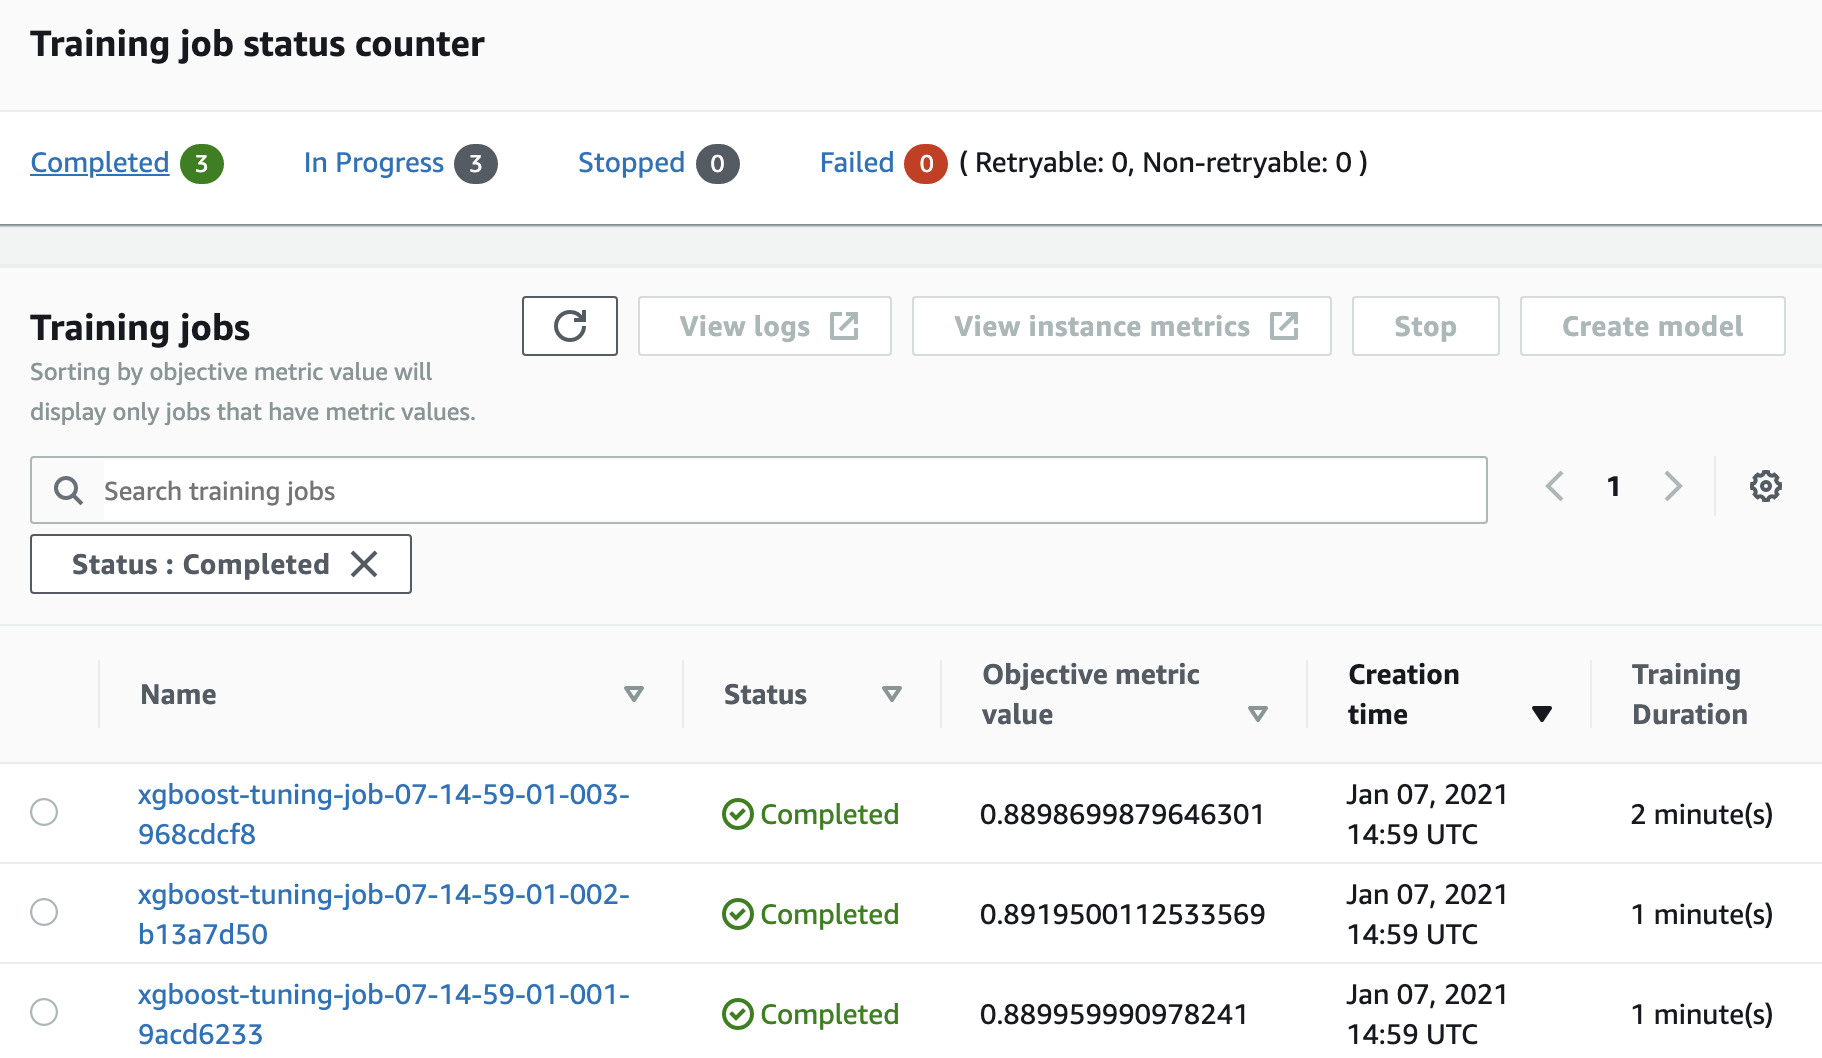

In [89]:
Image("img/training_jobs.png")

and also the best training job that we can either manually use or look to integrate into a pipeline

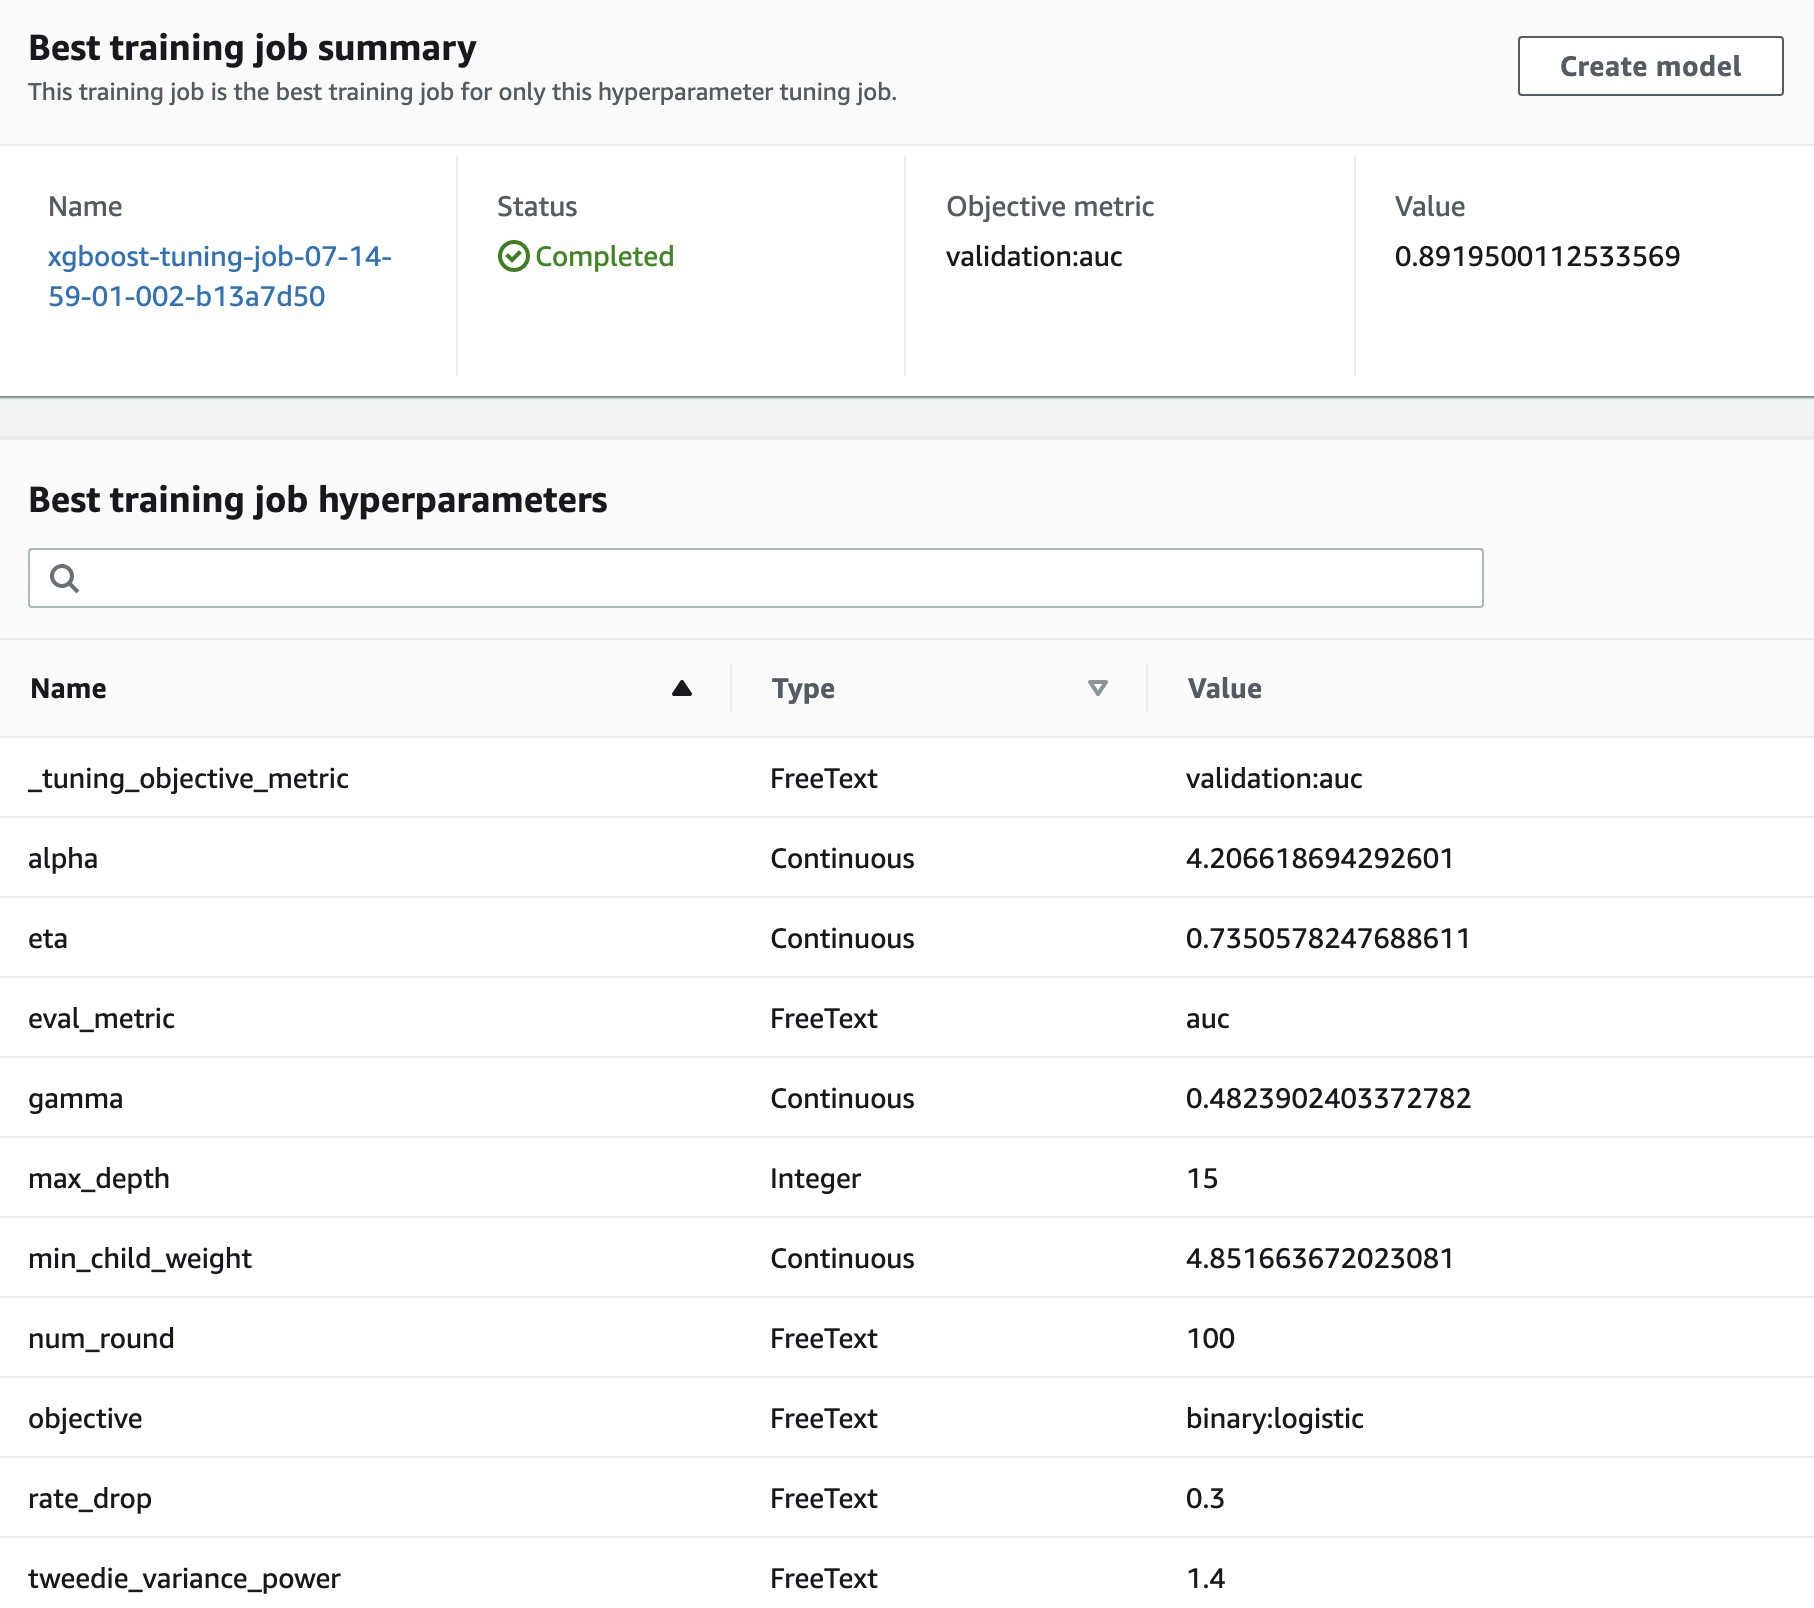

In [91]:
Image("img/best_training_job.png")

So, we now will get Sagemaker to do some autmatic tuning for us and we can check those results with any of the above methods!

We can also use another method which will allow us to define another estimator and then use it to update models and endpoints

This will be used in the next section when we talk about a pipeline

So (again), first let's define a new estimator to change some of the variables

In [80]:
#
# tuning_xgb = sagemaker.estimator.Estimator(image_uri=xgboost_container,
#                                           hyperparameters=hyperparameters,
#                                           role=sagemaker.get_execution_role(), 
#                                           instance_count=1, 
#                                           instance_type=instance_type,
#                                           output_path=s3_output_location,
#                                           sagemaker_session=sess,
#                                           max_run=180)

In [81]:
#
# from time import gmtime, strftime, sleep
# from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# tuning_job_name = 'xgboost-tuningjob-' + strftime("%d-%H-%M-%S", gmtime())

# hyperparameter_ranges = {
#                         'eta': ContinuousParameter(0.1, 0.5),
#                         'min_child_weight': ContinuousParameter(1, 10),
#                         'alpha': ContinuousParameter(0, 8),
#                         'max_depth': IntegerParameter(0, 20),
#                         'gamma': ContinuousParameter(0, 5)
#                         }

# objective_metric_name = 'validation:auc'

# tuner = HyperparameterTuner(tuning_xgb,
#                             objective_metric_name,
#                             hyperparameter_ranges,
#                             max_jobs=20,
#                             max_parallel_jobs=3,
#                             strategy='Random')

In [82]:
#
# tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

In [83]:
#
# smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [84]:
#
# tuner_predictor = tuner.deploy(initial_instance_count=1,
#                                    model_name="xgb-tuner-model-01",
#                                    endpoint_name="xgb-tuner-endpoint-01",
#                                    instance_type=instance_type,
#                                    serializer=CSVSerializer(),
#                                    deserializer=None)

and finally we need to clean up all our resources

In [85]:
smote_predictor.delete_model()
smote_predictor.delete_endpoint()
sm_client = boto3.client('sagemaker', region_name=boto3.Session().region_name)
waiter = sm_client.get_waiter('endpoint_deleted')
waiter.wait(EndpointName="xgb-smote-endpoint-02")